In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:


filename = "FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_12_normal.h5"

# 以只读方式打开 HDF5 文件
with h5py.File(filename, "r") as f:
    print("HDF5 文件中包含的数据集:")
    for key in f.keys():
        print(f"  {key} -> shape={f[key].shape}, dtype={f[key].dtype}")

    # 读取具体矩阵，例如 G_NM
    G_NM = f["G_NM"][:]
    print("G_NM 内容:\n", G_NM)

    # 读取 Q_FMM
    Q_FMM = f["Q_FMM"][:]
    # print("Q_FMM 内容:", Q_FMM)
    print("Q_FMM 形状:", Q_FMM.shape)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_12_normal.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def _to_numpy(arr):
    """将可能是 cupy.ndarray 的数组安全转为 numpy.ndarray。"""
    try:
        import cupy as cp  # 若未安装会触发 ImportError
        if isinstance(arr, cp.ndarray):
            return cp.asnumpy(arr)
    except Exception:
        pass
    return np.asarray(arr)

def plot_q_fmm_slices(Q_FMM, mode='abs', save_path=None):
    """
    绘制 Q_FMM 的 4 个子图；第 i 张子图画出 j=0..3 的曲线：y[f] = Q_FMM[f, j, i] 的选定分量.
    
    参数:
        Q_FMM : ndarray, 形状应为 (513, 4, 4)，复数(complex)
        mode  : str, 可选 {'abs', 'real', 'imag', 'phase'}
                'abs'   -> |Q|（幅度, magnitude）
                'real'  -> Re(Q)（实部, real part）
                'imag'  -> Im(Q)（虚部, imaginary part）
                'phase' -> ∠Q（相位, phase, 单位 radians）
        save_path : str or None，若给出则保存图片至该路径
    """
    Q = _to_numpy(Q_FMM)
    if Q.ndim != 3 or Q.shape[1] != 4 or Q.shape[2] != 4:
        raise ValueError(f"Q_FMM 形状应为 (F,4,4)，收到 {Q.shape}")
    F = Q.shape[0]
    x = np.arange(F)

    def pick(y):
        if mode == 'abs':
            return np.abs(y)
        elif mode == 'real':
            return y.real
        elif mode == 'imag':
            return y.imag
        elif mode == 'phase':
            return np.angle(y)
        else:
            raise ValueError(f"未知 mode: {mode}")

    # 标签（label）与轴标题（axis label）
    ylabel_map = {
        'abs':   r'$|Q_{f,j,i}|$',
        'real':  r'$\mathrm{Re}\{Q_{f,j,i}\}$',
        'imag':  r'$\mathrm{Im}\{Q_{f,j,i}\}$',
        'phase': r'$\angle Q_{f,j,i}\ \mathrm{(rad)}$',
    }
    ylab = ylabel_map.get(mode, r'$|Q_{f,j,i}|$')

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    axes = axes.ravel()

    for i in range(4):
        ax = axes[i]
        for j in range(4):
            y = pick(Q[:, j, i])  # 取 (f, j, i) 序列
            ax.plot(x, y, label=f'j={j}')
        ax.set_title(f'i = {i}')
        ax.set_ylabel(ylab)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
    axes[-1].set_xlabel('frequency bin f')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()
    return fig


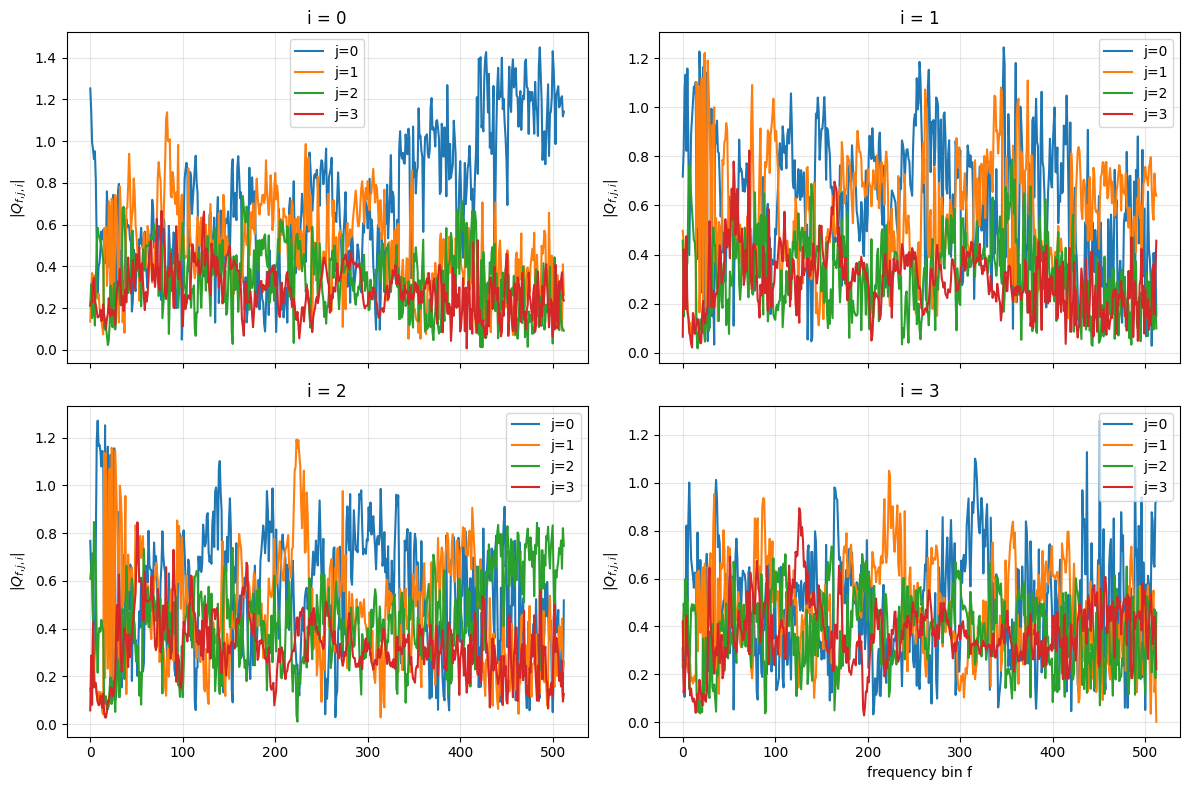

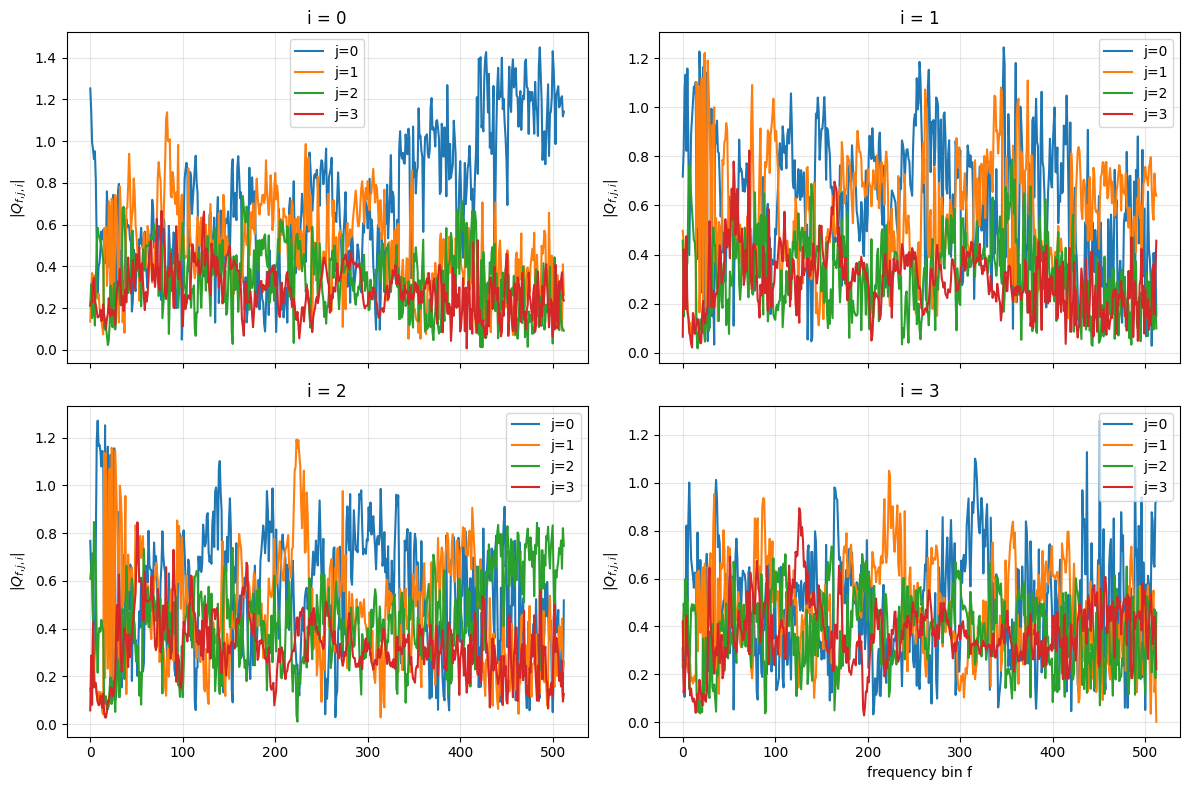

In [ ]:
plot_q_fmm_slices(Q_FMM, mode='abs')

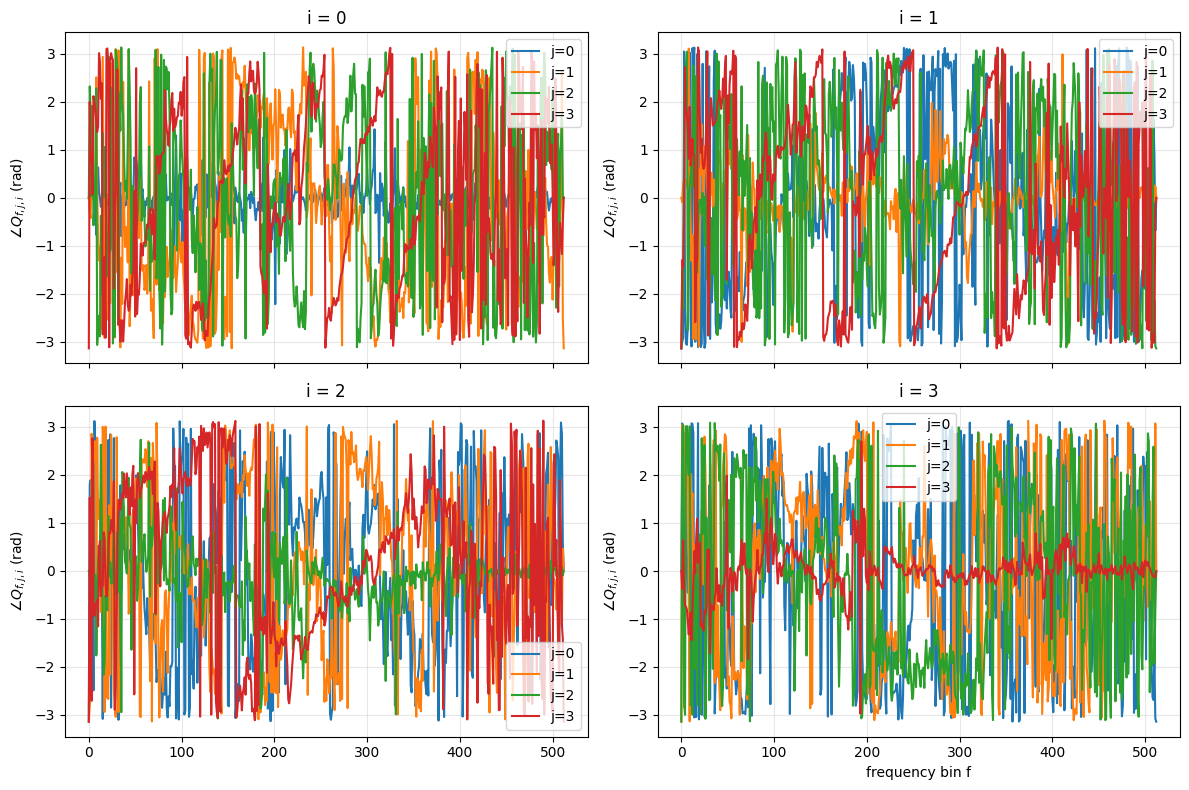

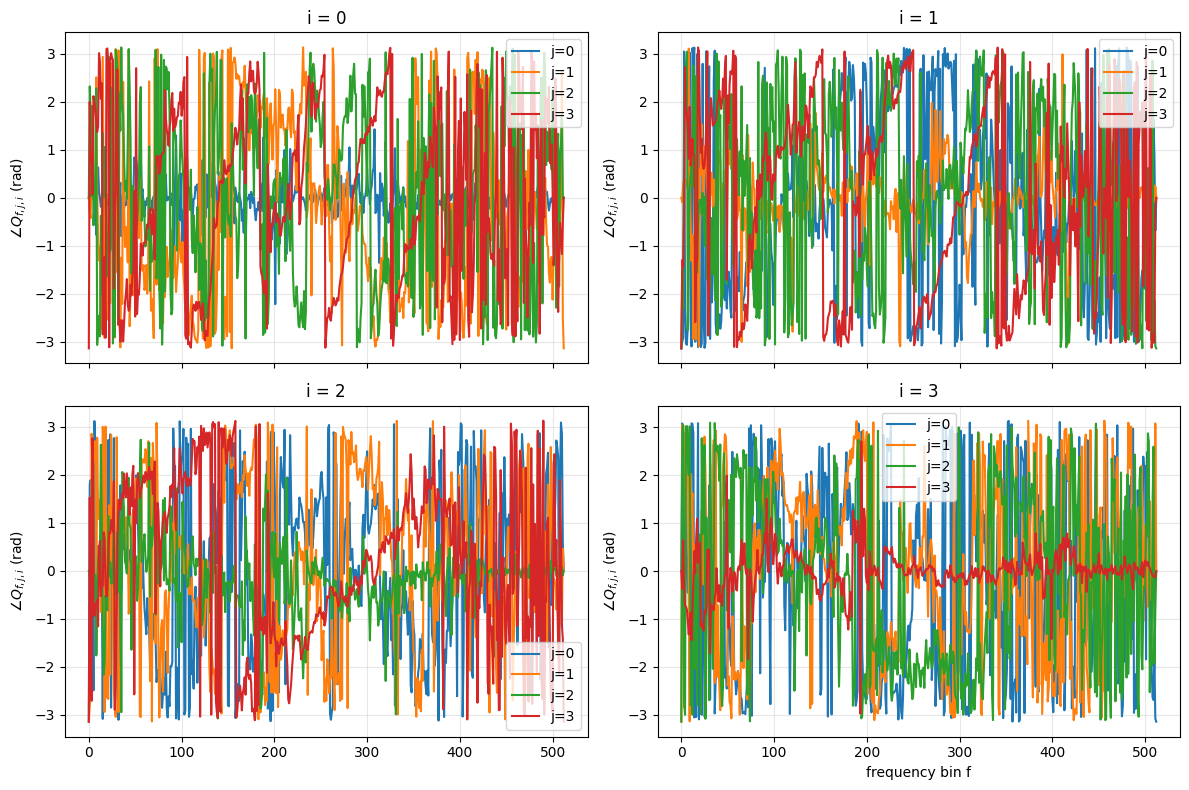

In [ ]:
plot_q_fmm_slices(Q_FMM, mode='phase')

In [ ]:
print("G_NM shape:", G_NM.shape)   # (N, M)
print("Q_FMM shape:", Q_FMM.shape) # (F, M, M)

F, M, _ = Q_FMM.shape
N = G_NM.shape[0]

for f_idx in [0, 100, 200]:  # 示例：挑几个频点
    Q_f = Q_FMM[f_idx]
    P_f = np.linalg.inv(Q_f)  # 原域特征向量矩阵
    print(f"\n频点 f={f_idx}:")

    for n in range(N):
        eigvals = G_NM[n]            # 对角化域的特征值
        eigvecs = P_f                # 每列是一个特征向量
        print(f"  源 {n}:")
        for m in range(M):
            print(f"    特征值 λ={eigvals[m]:.4f}, 特征向量={eigvecs[:, m]}")

G_NM shape: (3, 4)
Q_FMM shape: (513, 4, 4)

频点 f=0:
  源 0:
    特征值 λ=0.6182, 特征向量=[ 0.59941344+0.j -0.06614194+0.j -0.15312047+0.j  0.27257809+0.j]
    特征值 λ=0.0978, 特征向量=[2.5663109 +0.j 3.03940093+0.j 2.17922186+0.j 2.06927456+0.j]
    特征值 λ=0.1854, 特征向量=[1.56463726+0.j 0.87801925+0.j 2.22868955+0.j 1.23226617+0.j]
    特征值 λ=0.1009, 特征向量=[1.9994804 +0.j 2.40475602+0.j 2.67557843+0.j 4.1269524 +0.j]
  源 1:
    特征值 λ=0.0725, 特征向量=[ 0.59941344+0.j -0.06614194+0.j -0.15312047+0.j  0.27257809+0.j]
    特征值 λ=0.8061, 特征向量=[2.5663109 +0.j 3.03940093+0.j 2.17922186+0.j 2.06927456+0.j]
    特征值 λ=0.1127, 特征向量=[1.56463726+0.j 0.87801925+0.j 2.22868955+0.j 1.23226617+0.j]
    特征值 λ=0.0218, 特征向量=[1.9994804 +0.j 2.40475602+0.j 2.67557843+0.j 4.1269524 +0.j]
  源 2:
    特征值 λ=0.1701, 特征向量=[ 0.59941344+0.j -0.06614194+0.j -0.15312047+0.j  0.27257809+0.j]
    特征值 λ=0.0644, 特征向量=[2.5663109 +0.j 3.03940093+0.j 2.17922186+0.j 2.06927456+0.j]
    特征值 λ=0.1057, 特征向量=[1.56463726+0.j 0.87801925+0.j 2.22868955

In [3]:

def _unwrap_phase(x):
    """相位解缠（phase unwrapping, 沿最后一维）。"""
    return np.unwrap(np.angle(x), axis=-1)

def estimate_theta_single_freq(a_f, f_hz, d_list = [0,0.05,0.15,0.20], c=343.0):
    """
    单频 DOA(方向, Direction of Arrival) 估计（支持非均匀阵列）。

    模型:
        a_f[m] = A(f) * exp(-j * 2π f / c * d[m] cosθ)

    参数:
        a_f   : complex ndarray, shape (M,)
        f_hz  : float, 物理频率(Hz)
        d_list: list or ndarray, 各阵元位置(m)，例如 [0,0.05,0.15,0.20]
        c     : float, 声速(m/s)

    返回:
        theta_hat     : float, 估计角(弧度, rad)
        theta_std_rad : float, 标准差(弧度)
        kappa_hat     : float, 斜率 κ = (2π f / c) * cosθ
    """
    a_f = np.asarray(a_f).reshape(-1)
    d_arr = np.asarray(d_list, dtype=float).reshape(-1)
    M = a_f.shape[0]
    assert d_arr.shape[0] == M, "d_list 长度必须与 a_f 一致"

    # 去除未知幅度 A(f)：相对第一个阵元归一化
    ratio = a_f / (a_f[0] + 1e-12)
    phi = np.unwrap(np.angle(ratio))  # 相位展开

    # 线性回归: phi[m] ≈ - κ * d[m]，中心化削弱截距
    X = d_arr - d_arr.mean()
    y = phi
    kappa_hat = - (X @ y) / (X @ X + 1e-12)

    # 拟合 & 残差
    y_fit = -kappa_hat * d_arr
    resid = y - y_fit
    dof = max(M - 1, 1)
    sigma_phi2 = float((resid @ resid) / dof)
    var_kappa = sigma_phi2 / (X @ X + 1e-12)

    # 反解 θ
    alpha = c / (2*np.pi*f_hz + 1e-12)  # cosθ = alpha * κ
    cos_theta_hat = np.clip(kappa_hat * alpha, -1.0, 1.0)
    theta_hat = float(np.arccos(cos_theta_hat))

    # 误差传播
    sin_theta = max(np.sin(theta_hat), 1e-9)
    dtheta_dkappa = alpha / sin_theta
    theta_std_rad = float(np.sqrt(var_kappa) * abs(dtheta_dkappa))

    return theta_hat, theta_std_rad, kappa_hat

def estimate_theta_multi_freq(a_FM, f_bins_hz, d, c=343.0, var_weighted=True):
    """
    多频融合 DOA 估计（weighted circular mean）。
    """
    F, M = a_FM.shape
    theta_f, theta_std_f = [], []
    for f in range(F):
        th, th_std, _ = estimate_theta_single_freq(a_FM[f], f_bins_hz[f], [0,0.05,0.15,0.20], c)
        theta_f.append(th)
        theta_std_f.append(max(th_std, 1e-6))
    theta_f = np.array(theta_f)
    theta_std_f = np.array(theta_std_f)

    # 以 1/Var 作为权重在单位圆上平均
    if var_weighted:
        w = 1.0 / (theta_std_f**2)
    else:
        w = np.ones_like(theta_std_f)
    w /= (w.sum() + 1e-12)

    cos_hat = float((w * np.cos(theta_f)).sum())
    sin_hat = float((w * np.sin(theta_f)).sum())
    theta_fused = float(np.arctan2(sin_hat, cos_hat))

    # 融合标准差（近似为方差调和平均的平方根）
    theta_fused_std = float(np.sqrt(1.0 / (1e-12 + (1.0 / (theta_std_f**2)).sum())))
    return theta_f, theta_std_f, theta_fused, theta_fused_std

# ============== 选列策略：能量最大 vs 显式(G_NM[n,m])指定 ==============

def _pick_max_energy_column(P_f):
    """返回 (m_star, energy_list)：按列二范数平方最大。"""
    col_energy = np.sum(np.abs(P_f)**2, axis=0)
    m_star = int(np.argmax(col_energy))
    return m_star, col_energy

def _extract_steering_from_Q(Q_FMM, fixed_col):
    """
    从 Q_FMM(F,M,M) 提取每频点导向向量 a_f。
    若 fixed_col 为 None：每频点用最大能量列；否则固定用第 fixed_col 列。
    返回:
        a_FM    : (F,M)
        idxs    : (F,) 每频点选择的列下标
        energies: (F,M) 每频点各列能量（便于诊断）
    """
    F, M, _ = Q_FMM.shape
    a_FM = np.zeros((F, M), dtype=np.complex128)
    idxs = np.zeros(F, dtype=int)
    energies = np.zeros((F, M), dtype=float)
    for f in range(F):
        P_f = np.linalg.inv(Q_FMM[f])  # (M,M)
        if fixed_col is None:
            m_star, col_energy = _pick_max_energy_column(P_f)
        else:
            if not (0 <= fixed_col < M):
                raise ValueError(f"fixed_col 超界: {fixed_col} 不在 [0,{M-1}]")
            m_star = fixed_col
            col_energy = np.sum(np.abs(P_f)**2, axis=0)
        a_FM[f] = P_f[:, m_star]
        idxs[f] = m_star
        energies[f] = col_energy
    return a_FM, idxs, energies

# ============== 主流程：从 HDF5 读取，选择列，估计 θ ==============

def doa_from_h5_qfmm(
    h5_path: str,
    fs_hz: float,
    n_fft: int,
    d_m: float,
    c: float = 343.0,
    fmin_hz: float = 200.0,
    fmax_hz = None,
    var_weighted: bool = True,
    select_g_idx = None,  # 新增：(n,m) 显式指定
):
    """
    从 HDF5 读取 Q_FMM（必需）与 G_NM（用于校验与说明），
    并按策略选择导向向量列，进行多频 DOA 估计。

    参数:
        select_g_idx : 若为 (n,m)，固定用列 m（即使用 G_NM[n,m] 对应的特征方向）。
                       若为 None，则每频点自动选择“能量最大列”。

    返回:
        dict:
            theta_f, theta_std_f, theta_fused, theta_fused_std, f_sel_hz,
            picked_col, energies, g_value (若提供 select_g_idx)
    """
    with h5py.File(h5_path, "r") as f:
        Q_FMM = f["Q_FMM"][:]         # (F,M,M)
        G_NM = f["G_NM"][:] if "G_NM" in f else None  # (N,M) 可能不存在旧文件

    F, M, _ = Q_FMM.shape

    # 频率刻度（与 rfft 对齐）
    freqs_hz = np.fft.rfftfreq(n_fft, d=1.0/fs_hz)
    if len(freqs_hz) != F:
        raise ValueError(f"频点数不匹配: Q_FMM F={F}, 但由 fs={fs_hz}, n_fft={n_fft} 得到 {len(freqs_hz)}")

    # 解析显式选择 (n,m)
    fixed_col = None
    g_value = None
    if select_g_idx is not None:
        if G_NM is None:
            raise ValueError("HDF5 中未找到 G_NM，但提供了 select_g_idx；无法校验 (n,m)。")
        n, m = select_g_idx
        N = G_NM.shape[0]
        if not (0 <= n < N and 0 <= m < M):
            raise ValueError(f"select_g_idx 越界: (n={n}, m={m})，应满足 n∈[0,{N-1}], m∈[0,{M-1}]")
        fixed_col = m
        g_value = float(G_NM[n, m])  # 记下用户指定的“特征值”
    # 提取导向向量（固定列 or 能量最大列）
    a_FM, picked_col, energies = _extract_steering_from_Q(Q_FMM, fixed_col=fixed_col)

    # 频段选择：避开直流与空间混叠
    if fmax_hz is None:
        fmax_hz = min(fs_hz/2.0, c/(2.0*d_m))
    sel = (freqs_hz >= fmin_hz) & (freqs_hz <= fmax_hz)
    a_sel = a_FM[sel]
    f_sel_hz = freqs_hz[sel]

    # 多频 DOA 估计
    theta_f, theta_std_f, theta_fused, theta_fused_std = estimate_theta_multi_freq(
        a_sel, f_sel_hz, d=d_m, c=c, var_weighted=var_weighted
    )

    out = {
        "theta_f": np.array(theta_f),
        "theta_std_f": np.array(theta_std_f),
        "theta_fused": float(theta_fused),
        "theta_fused_std": float(theta_fused_std),
        "f_sel_hz": np.array(f_sel_hz),
        "picked_col": picked_col,
        "energies": energies,
    }
    if g_value is not None:
        out["g_value"] = g_value
        out["select_g_idx"] = select_g_idx
    return out


In [12]:

# h5_file = "FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=twoangle-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal.h5"

fs_hz   = 48000   # 采样率(Hz) —— 和分离时一致
n_fft   = 1024      # STFT n_fft  —— 与 F=513 对应 (rfft: 1024 -> 513 bins)
d_m     = 0.05     # 阵元间距(m) —— 按你的麦克风阵列填写
c       = 343.0     # 声速(m/s)

# 频段选择与融合策略
fmin_hz = 300.0     # 避开直流与极低频
fmax_hz = None      # 自动取 min(fs/2, c/(2d)) 防混叠
var_weighted = True
def angleca(i,h5_file):
    select_g_idx =(2,i)
    print(i)

    res = doa_from_h5_qfmm(
            h5_path=h5_file, fs_hz=fs_hz, n_fft=n_fft, d_m=d_m, c=c,
            fmin_hz=fmin_hz, fmax_hz=fmax_hz, var_weighted=var_weighted,
            select_g_idx=select_g_idx  
        )

    # 输出结果（角度用度）
    deg = lambda rad: rad * 180.0 / np.pi
    print(f"[多频融合] θ = {deg(res['theta_fused']):.2f}°  ±  {deg(res['theta_fused_std']):.2f}°")
    print(f"使用频点数: {len(res['f_sel_hz'])}, 频率范围: [{res['f_sel_hz'][0]:.1f}, {res['f_sel_hz'][-1]:.1f}] Hz")

    # 可选：查看部分频点单频估计
    for idx in np.linspace(0, len(res['theta_f'])-1, num=2, dtype=int):
        print(f"f={res['f_sel_hz'][idx]:6.1f} Hz -> θ={deg(res['theta_f'][idx]):6.2f}°, σ={deg(res['theta_std_f'][idx]):.2f}°")

In [10]:

def _rad2deg(x_rad):
    return np.asarray(x_rad, dtype=float) * 180.0 / np.pi

def _wrap_to_0_180(deg_vals):
    """
    将角度折叠/限制到 [0, 180] 区间内（单位：度）。
    对任何输入角度 x（可能负、>360），先做 mod 到 [0,360)，
    再对 >180 的部分做“对称折返”(360 - x) 映射到 [0,180]。
    """
    x = np.asarray(deg_vals, dtype=float)
    x = np.mod(x, 360.0)
    x = np.where(x < 0.0, x + 360.0, x)
    x = np.where(x > 180.0, 360.0 - x, x)
    return x

def plot_doa_angle_vs_freq_4panels(h5_file, i_list=(0, 1, 2, 3)):
    """
    Create a 2x2 figure. For each i in i_list, run doa_from_h5_qfmm and plot:
      - Per-frequency angle θ(f) in degrees (folded to [0,180])
      - A horizontal line for fused angle (±1σ if available), in degrees

    Notes:
      - All labels and legends are in English.
      - Y-axis is limited to [0, 180] degrees.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    axes = axes.ravel()

    for ax, i in zip(axes, i_list):
        select_g_idx = (0, i)
        res = doa_from_h5_qfmm(
            h5_path=h5_file,
            fs_hz=fs_hz, n_fft=n_fft, d_m=d_m, c=c,
            fmin_hz=fmin_hz, fmax_hz=fmax_hz, var_weighted=var_weighted,
            select_g_idx=select_g_idx
        )

        f_hz = np.asarray(res["f_sel_hz"], dtype=float)

        # Per-frequency estimates -> degrees, then fold to [0,180]
        theta_f_deg = _rad2deg(res["theta_f"])
        theta_f_deg = _wrap_to_0_180(theta_f_deg)

        ax.plot(f_hz, theta_f_deg, linewidth=1.8, label="Per-frequency estimate")

        # Optional: per-frequency std as shaded band (no folding on std; use symmetric band then clip display range)
        if "theta_std_f" in res and res["theta_std_f"] is not None:
            theta_std_f_deg = _rad2deg(res["theta_std_f"])
            y_low = np.clip(theta_f_deg - theta_std_f_deg, 0.0, 180.0)
            y_high = np.clip(theta_f_deg + theta_std_f_deg, 0.0, 180.0)
            ax.fill_between(f_hz, y_low, y_high, alpha=0.20, step=None,
                            label="Per-frequency ±1σ")

        # Fused angle line (±1σ if provided) -> degrees, fold to [0,180]
        theta_fused_deg = float(_rad2deg(res["theta_fused"]))
        theta_fused_deg = float(_wrap_to_0_180(theta_fused_deg))
        ax.axhline(theta_fused_deg, linestyle="--", linewidth=1.8,
                   label=f"Fused angle = {theta_fused_deg:.2f}°")

        theta_fused_std_deg = float(_rad2deg(res.get("theta_fused_std", 0.0)))
        if theta_fused_std_deg > 0:
            # 以未折返的 std 画对称带，显示时剪裁到 [0,180]
            up = np.clip(theta_fused_deg + theta_fused_std_deg, 0.0, 180.0)
            dn = np.clip(theta_fused_deg - theta_fused_std_deg, 0.0, 180.0)
            ax.axhline(up, linestyle=":", linewidth=1.2, label=f"Fused +1σ = {up:.2f}°")
            ax.axhline(dn, linestyle=":", linewidth=1.2, label=f"Fused -1σ = {dn:.2f}°")

        # Axes, labels, title (English), limits
        ax.set_title(f"i = {i}: Angle vs Frequency")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Angle θ (deg)")
        ax.set_ylim(0.0, 180.0)
        ax.grid(True, linestyle=":")
        ax.legend(loc="best", fontsize=9)

        # If desired for wide ranges:
        # ax.set_xscale("log")

    # Hide extra axes if i_list has fewer than 4 entries
    for k in range(len(i_list), 4):
        fig.delaxes(axes[k])

    plt.show()

In [28]:
# ---- 必填：你的文件与阵列参数
# h5_file = "FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal.h5"
# h5_file ="FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=angle-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal.h5"
# h5_file = "FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=angle-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal.h5"
# h5_file = "FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_02_hard.h5"
h5_file = "FastMNMF2_IP-param-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal_3.h5"

fs_hz   = 48000   # 采样率(Hz) —— 和分离时一致
n_fft   = 1024      # STFT n_fft  —— 与 F=513 对应 (rfft: 1024 -> 513 bins)
d_m     = 0.05     # 阵元间距(m) —— 按你的麦克风阵列填写
c       = 343.0     # 声速(m/s)

# 频段选择与融合策略
fmin_hz = 300.0     # 避开直流与极低频
fmax_hz = None      # 自动取 min(fs/2, c/(2d)) 防混叠
var_weighted = True

with h5py.File(h5_file, "r") as f:

    G_NM = f["G_NM"][:]
    print("G_NM 内容:\n", G_NM)




G_NM 内容:
 [[6.96653575e-01 3.06561341e-01 6.00081832e-10 1.40663443e-10]
 [1.30693322e-01 2.17206853e-01 3.56558099e-01 2.92840963e-01]
 [7.78600325e-02 1.82890683e-01 3.30649139e-01 4.03552844e-01]]


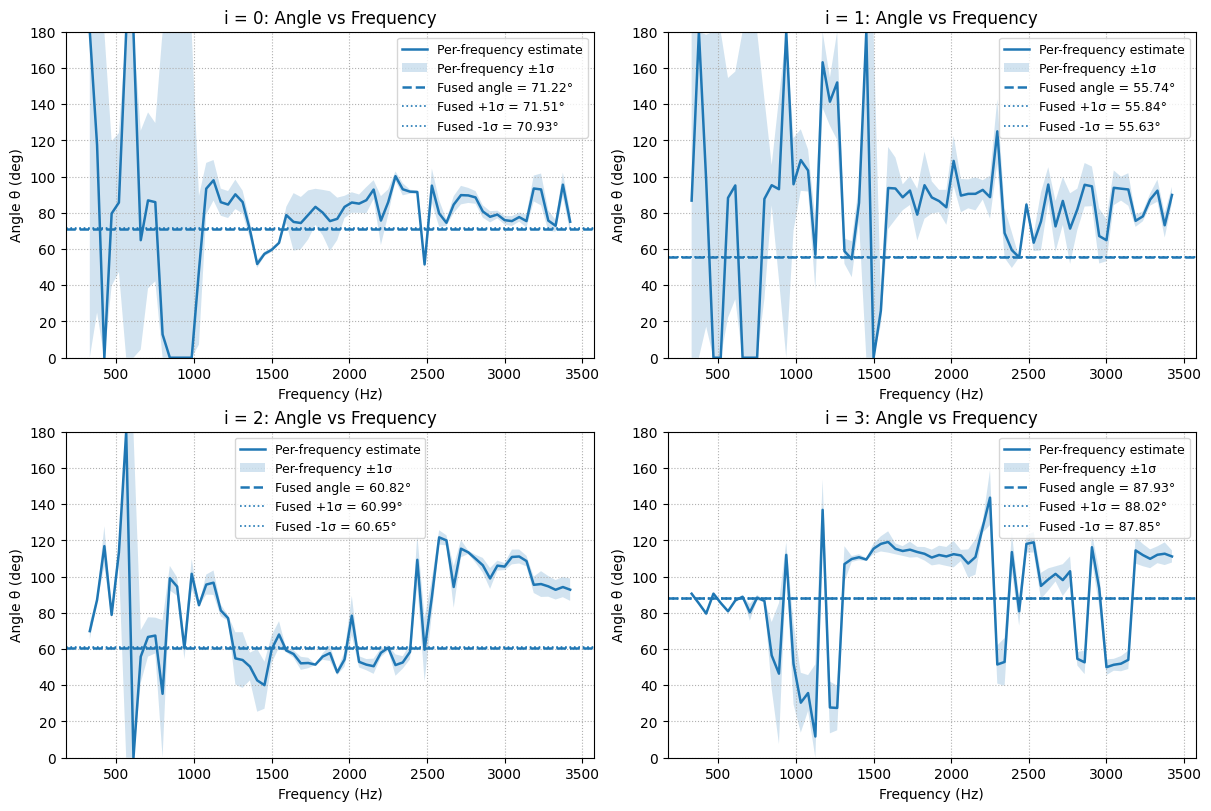

In [29]:
plot_doa_angle_vs_freq_4panels(h5_file=h5_file, i_list=(0,1,2,3))